# Compute hypocentral depth distribution

In [1]:
%matplotlib inline
import os
import re
import sys
import h5py
import numpy
try:
    import cPickle as pickle
except:
    import pickle
import matplotlib.pyplot as plt
from openquake.mbt.oqt_project import OQtProject

In [2]:
project_pickle_filename = os.environ.get('OQMBT_PROJECT')
oqtkp = OQtProject.load_from_file(project_pickle_filename)
model_id = oqtkp.active_model_id
model = oqtkp.models[model_id]
prj_dir = os.path.dirname(project_pickle_filename)
# hdf5 files
hypo_depths_hdf5_filename = os.path.join(prj_dir, oqtkp.hypo_depths_hdf5_filename)
# set source ID
try:
    area_source_ids_list = getattr(oqtkp,'active_source_id')
except:
    print('Active source ID not defined in the OQMBT project')
    area_source_ids_list = ['10']
print('Processing area source with ID:', area_source_ids_list)
src_id = area_source_ids_list[0]

Processing area source with ID: ['I']


## Create catalogue for the analysed area source
### Read the declustered catalogue

In [3]:
pickle_filename = os.path.join(prj_dir, oqtkp.models[model_id].declustered_catalogue_pickle_filename)
fin = open(pickle_filename, 'rb') 
catalogue = pickle.load(fin)
fin.close()
print('The calogue contains %d earthquakes' % (len(catalogue.data['magnitude'])))

The calogue contains 2643 earthquakes


### Create catalogue for the selected areas

In [4]:
from openquake.mbt.tools.area import create_catalogue
fcatal = create_catalogue(model, catalogue, area_source_ids_list)

## Create the hypocentral depth histogram

[ 0  7 15]
[ 7  8 10]


/Users/mpagani/Repos/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:2966: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


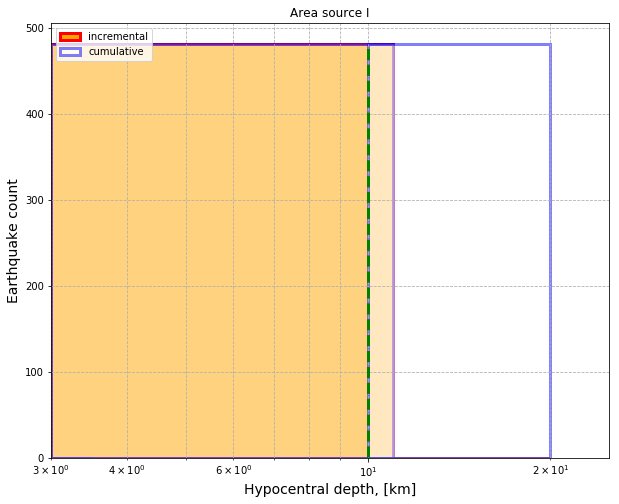

In [5]:
bin_edges = numpy.array(model.hypo_depth_bin_edges)

depths = fcatal.data['depth']
sdep = numpy.sort(depths)
sdcs = numpy.cumsum(numpy.ones_like(sdep))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

histo, _ = numpy.histogram(depths, bins=bin_edges)
histocum = numpy.cumsum(histo)
    
print(bin_edges[0:-1])
print(numpy.diff(bin_edges))

plt.bar(bin_edges[0:-1], 
        histo, 
        width=numpy.diff(bin_edges),
        edgecolor='red', 
        facecolor='orange', 
        linewidth=3, 
        alpha=1.0,
        label='incremental')

plt.plot(sdep, sdcs, '--g', linewidth=3)

plt.bar(bin_edges[0:-1], 
        histocum, 
        width=numpy.diff(bin_edges),
        edgecolor='blue', 
        facecolor='white', 
        linewidth=3, 
        alpha=0.5,
        label='cumulative')

plt.xlabel(r'Hypocentral depth, [km]', fontsize=14)
plt.ylabel(r'Earthquake count', fontsize=14)
plt.grid(which='both', linestyle='--')
plt.title('Area source %s' % area_source_ids_list[0])
plt.xscale('log')
plt.legend(loc=2)
xlimits = plt.xlim([0, max(bin_edges)])

[ 0  7 15]


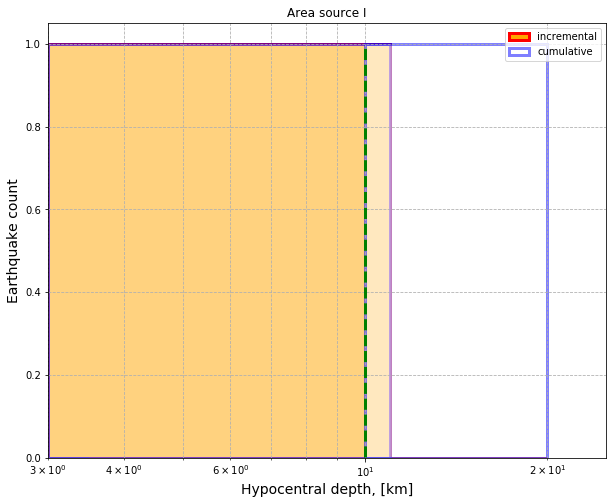

In [6]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

histo = histo.astype(float)
histocum = histocum.astype(float)

smm = sum(histo)
histo /= smm
histocum /= max(histocum)

print(bin_edges[0:-1])

plt.bar(bin_edges[0:-1], histo, 
        width=numpy.diff(bin_edges),
        edgecolor='red', 
        facecolor='orange', 
        linewidth=3, 
        alpha=1.0,
        label='incremental')

plt.plot(sdep, sdcs/max(sdcs), '--g', linewidth=3)

plt.bar(bin_edges[0:-1], 
        histocum, 
        width=numpy.diff(bin_edges),
        edgecolor='blue', 
        facecolor='white', 
        linewidth=3, 
        alpha=0.5,
        label='cumulative')

plt.xlabel(r'Hypocentral depth, [km]', fontsize=14)
plt.ylabel(r'Earthquake count', fontsize=14)
plt.grid(which='both', linestyle='--')
plt.title('Area source %s' % area_source_ids_list[0])
plt.xscale('log')
plt.legend(loc=1)
xlimits = plt.xlim([0, max(bin_edges)])

In [7]:
from decimal import *

aa = re.sub('\.hdf5', '', os.path.basename(hypo_depths_hdf5_filename))
csv_filename = '{:s}-{:s}-{:s}.csv'.format(aa, model_id, src_id)
print(csv_filename)
#
#
path = os.path.join(prj_dir, 'hypo_depths')
if not os.path.exists(path):
    os.makedirs(path)
    print('Creating folder: {:s}'.format(path))
else:
    print('Folder {:s} exists'.format(path))
#
#
dps = (bin_edges[1:] + bin_edges[:-1]) / 2
print(dps)
wei = numpy.around(histo, 2)
wei /= sum(wei)
wei = numpy.around(wei,2)
#print(wei)

x_sum = sum(wei[0:-1])
x_diff = 1.0-x_sum
if (wei[-1]-x_diff)<0.01:
    wei[-1] = x_diff
else:
    raise SystemExit('Weight correction failed! Check original weight assignments')
#print(wei)
#
# Writing csv file
outfile = os.path.join(path, csv_filename)
print('Writing {:s}'.format(outfile))
fou = open(outfile, 'w')
fou.write('depth,weight\n')
for dep, wgh in zip(dps, wei):
    if wgh > 1e-10:
        fou.write('{:.2f},{:.2f}\n'.format(dep, wgh))
fou.close()
jjj = numpy.nonzero(wei > 1e-10)

hypo_depths-model01-I.csv
Folder /Users/mpagani/Repos/models/phase3/ita19/model/crustal/model01/hypo_depths exists
[ 3.5 11.  20. ]
Writing /Users/mpagani/Repos/models/phase3/ita19/model/crustal/model01/hypo_depths/hypo_depths-model01-I.csv


In [8]:
print('Writing', hypo_depths_hdf5_filename)
#
# open the hdf5 file
fhdf5 = h5py.File(hypo_depths_hdf5_filename,'a')
#
# Update/create model group
if model_id in fhdf5.keys():
    print('Group exists. Set group %s' % (model_id))
    grp = fhdf5[model_id]
else:
    print('Create group: %s' % (model_id))
    grp = fhdf5.create_group(model_id)
#
# update/create source group
if src_id in fhdf5[model_id].keys():
    print('Group exists. Set group %s' % (src_id))
    grpsrc = fhdf5[model_id][src_id]
else:
    print('Create group: %s' % (src_id))
    grpsrc = fhdf5[model_id].create_group(src_id)
#
# update/create datasets
dset_ids = ['b_edges', 'hist', 'hist_cum', 'depth', 'weight']
for dset_id in dset_ids:
    if dset_id in grpsrc:
        del grpsrc[dset_id]
dataset = grpsrc.create_dataset(dset_ids[0], data=bin_edges)
dataset = grpsrc.create_dataset(dset_ids[1], data=histo)
dataset = grpsrc.create_dataset(dset_ids[2], data=histocum)
fhdf5.close()

Writing /Users/mpagani/Repos/models/phase3/ita19/model/crustal/model01/hypo_depths.hdf5
Create group: model01
Create group: I


In [9]:
#
# open the hdf5 containing the hypocentral depth information
hypo_dist_filename = os.path.join(oqtkp.directory, model.hypo_dist_filename)
fhdf5 = h5py.File(hypo_dist_filename,'a')
#
#
if src_id in fhdf5:
    del fhdf5[src_id]
#
# updating the dataset for the current area source
x = numpy.zeros(len(jjj[0]), dtype=[('depth','f4'),('wei', 'f4')])
x['wei'] = wei[jjj]
x['depth'] = dps[jjj] 

dset = fhdf5.create_dataset(src_id, data=x)
fhdf5.close()

print('{:s} updated - src {:s}'.format(hypo_dist_filename, src_id))

./model01/hypo_depths.hdf5 updated - src I
